# **End-to-end MNIST app using scanflow with agents**

### **Steps**

- **Training**: Define the training executor using Pytorch and the MNIST data.
- **Inference**: Define the inference executor to make predictions using a trained model.
    - **Agents**: Define the Tracker, Checker, Improver and Planner agent.
- **Detector**: Define a detector executor to both detect anomalies and pick a subset of them for retraining. It will be used by the Checker agent. Built-in Scanflow executor (from the paper).(https://colab.research.google.com/drive/1t0EgpPk5_mEMNb_AvN7yJ_Tz88bqgS9A). 
- **Retraining**: Define a retraining executor to retrain the model using x_train + x_chosen. It will be used by the Improver agent. Built-in Scanflow executor.
- **Dashboard**: Call the inference executor from a web application.

# Training

Let's get some MNIST data to train a CNN-based model.

In [1]:
import utils
x_train_sample, y_train_sample = utils.sample_train_mnist()
x_train_sample.shape

(1000, 28, 28)

We load 1k instances (from the original 60k) to make the training faster.

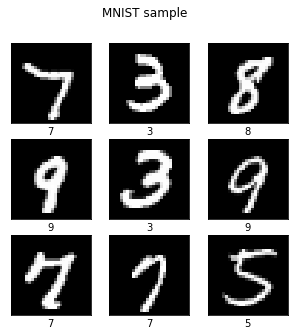

In [2]:
utils.show_numbers(x_train_sample, y_train_sample, title=f"MNIST sample")

Here we start the training executor definition. We need the following things:

- Python script: training.py
- Parameters for the script: model_name, x_train_path, y_train_path, etc.
- requirements: req_training.txt, the required libraries to build the training image.

In [9]:
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(1,'../..')
from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

# We can define a list of executors. In this case, we only have one executor.
executors = [Executor(name='training', 
                      file='training.py',
                      parameters={'model_name': 'mnist_cnn',
                                  
                                  'x_train_path': './mnist_sample/train_images.npy', 
                                  'y_train_path': './mnist_sample/train_labels.npy',
                                  
                                  'x_test_path': './mnist/test_images.npy',
                                  'y_test_path': './mnist/test_labels.npy'},
                      requirements='req_training.txt')           
            ]

# A workflow contains a list of executors and also special nodes. 
# In this case, we have only one offline special node: Tracker MLflow.
workflow1 = Workflow(name='training-mnist', 
                     executors=executors,
                     tracker=Tracker(mode='offline')) # No agents involved
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

12-Apr-21 23:12:39 -  INFO - [Tracker] Port 8002 is set successfully.



Setup = (
    Workflows: ['training-mnist']
)

All the experiments will be saved at MLflow UI: http://localhost:8002 (Offline Tracker)

Once we have defined training executor we build the images and start the containers.

In [10]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows()

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


We run the workflow to actually run the scripts inside the containers.

In this case, this running will perform the training so it will take some seconds.

In [11]:
deployer.run_workflows(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]12-Apr-21 23:12:47 -  INFO - [++] Running workflow: [training-mnist].
12-Apr-21 23:12:47 -  INFO - [+] Running env: [training-mnist:training].
12-Apr-21 23:13:00 -  INFO - [+] Running (training.py). 
12-Apr-21 23:13:00 -  INFO - [+] Output:  Train Epoch: 1 [0/1000 (0%)]	Loss: 2.299094
Successfully registered model 'mnist_cnn'.
2021/04/12 21:13:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mnist_cnn, version 1
Created version '1' of model 'mnist_cnn'.
 
12-Apr-21 23:13:00 -  INFO - [+] Environment (training-mnist-training) finished successfully. 
12-Apr-21 23:13:00 -  INFO - [+] Workflow: [training-mnist] was run successfully.
100%|██████████| 1/1 [00:13<00:00, 13.09s/it]

Elapsed time: 13.098422288894653


In [12]:
# deployer.stop_workflows()

# Inference



We load 1k of testing data to make predictions.

(1000, 28, 28)


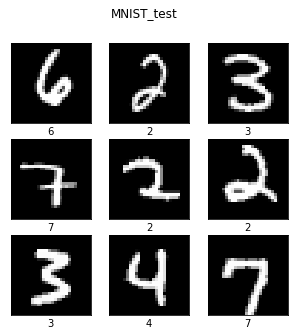

In [76]:
import utils

x_test_sample, y_test_sample = utils.sample_test_mnist()
print(x_test_sample.shape)
utils.show_numbers(x_test_sample, y_test_sample, title=f"MNIST_test")

Similar to the training part, we define the inference executor. We need the following:

- Python script: inference-batch.py
- Parameters for the script: x_inference_path, model_name and model_version.
- requirements: req_inference_batch.txt, the required libraries to build the inference image.

Apart from the inference executor we also define the special agents:
- **Tracker**: the one in charge of linking the multi agent system to the outside. For instance, it can get the x_inference and pass to the Checker agent.
- **Checker**: this agent calls the detector to get the anomalies and the chosen instances to be considered for the retraining. The Checker's output is the feedback.
- **Improver**: it decides what to do with the feedback. For instance, if n_anomalies > threshold, then perform a retraining with x_train + x_chosen.
- **Planner**: this agent receives the order from the Improver to make some changes in the original workflow. For instance, build a new inference executor.

In [77]:
import sys
import numpy as np
import os
sys.path.insert(1,'../..')

from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker, Checker, Improver, Planner, Predictor
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

# This executor needs the path where to feed the model to make predictions.
# It also needs a model name and version. This information can be found in the MLflow UI.
# This inference is of type "batch", meaning that predictor is a python script inside a container.

executors = [Executor(name='inference-batch', 
                      file='inference-batch.py',
                      parameters={'x_inference_path': './mnist_sample/test_images.npy',
                                 'model_name':'mnist_cnn', 'model_version':1},
                      requirements='req_inference_batch.txt')           
            ]

# 
workflow1 = Workflow(name='inference-mnist', 
                     executors=executors,
                     tracker=Tracker(mode='online'),
                     checker=Checker(mode='online'),
                     improver=Improver(mode='online'),
                     planner=Planner(mode='online'))
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

13-Apr-21 15:41:46 -  INFO - [Tracker] Port 8002 is in use by Tracker.
13-Apr-21 15:41:46 -  INFO - [Checker] Port 8004 is set successfully.
13-Apr-21 15:41:46 -  INFO - [Improver] Port 8006 is in use by Improver.
13-Apr-21 15:41:46 -  INFO - [Planner] Port 8007 is in use by Planner.



Setup = (
    Workflows: ['inference-mnist']
)

In [78]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows()
# deployer.pipeline() # Build, Start and Run

100%|██████████| 1/1 [00:00<00:00, 35.81it/s]


Let's test this executor, to see if it is working. 

In [79]:
deployer.run_workflows(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]13-Apr-21 15:41:51 -  INFO - [++] Running workflow: [inference-mnist].
13-Apr-21 15:41:51 -  INFO - [+] Running env: [inference-mnist:inference-batch].
13-Apr-21 15:41:54 -  INFO - [+] Running (inference-batch.py). 
13-Apr-21 15:41:54 -  INFO - [+] Output:     predictions
0            6
1            2
2            3
3            4
4            9
5            2
6            3
7            4
8            9
9            6
 
13-Apr-21 15:41:54 -  INFO - [+] Environment (inference-mnist-inference-batch) finished successfully. 
13-Apr-21 15:41:54 -  INFO - [+] Workflow: [inference-mnist] was run successfully.
100%|██████████| 1/1 [00:02<00:00,  2.66s/it]
13-Apr-21 15:41:54 -  INFO - [+] Elapsed time: 2.66 seconds


In [21]:
# deployer.stop_workflows()

# Detector

This executor contains the detector and the picker. In the sake of simplicity, we ommited the detector training part, instead, we provide the "detector inference" based on a pretrained model (detector.hdf5).

In [38]:
import sys
import numpy as np
import os
sys.path.insert(0,'../..')

from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker, Checker, Improver, Planner
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

# This detector-batch comprises an anomaly detector and a picker
# It requires the inference run_id from where to get the artifacts.
executors = [Executor(name='detector-batch', 
                      file='detector-batch.py',
                      parameters={'run_id': 'df7703c691f146c4a13b60287dd45abe', 
                                  'x_inference_artifact': 'x_inference.npy',
                                  'y_inference_artifact': 'y_inference.npy'
                                 },
                      requirements='req_detector.txt')           
            ]


workflow1 = Workflow(name='detector-mnist', 
                     executors=executors,
                     tracker=Tracker(mode='offline'))
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup


Setup = (
    Workflows: ['detector-mnist']
)

In [39]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows()
# deployer.pipeline() # Build, Start and Run

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


In [40]:
deployer.run_workflows(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]13-Apr-21 11:01:51 -  INFO - [++] Running workflow: [detector-mnist].
13-Apr-21 11:01:51 -  INFO - [+] Running env: [detector-mnist:detector-batch].
13-Apr-21 11:01:56 -  INFO - [+] Running (detector-batch.py). 
13-Apr-21 11:01:56 -  INFO - [+] Output:  2021-04-13 09:01:52.458648: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-04-13 09:01:52.458706: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-04-13 09:01:54.766991: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-13 09:01:54.768653: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared obje

# Retraining

This executor will be used by the Improver agent to retrain the model:

x_new_train = x_train+x_chosen

In [9]:
import sys
import matplotlib.pyplot as plt
import os
sys.path.insert(0,'../..')

from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")


executors = [Executor(name='retraining', 
                      file='retraining.py',
                      parameters={'model_name': 'mnist_cnn_retrained',
                                  'run_id': 'be066cefe8784a248aa3f6e89f70d4f6',
                                  'x_new_train_artifact': 'x_inference.npy', 
                                  'y_new_train_artifact': 'y_inference.npy',
                                  
                                  'x_test_path': './mnist/test_images.npy',
                                  'y_test_path': './mnist/test_labels.npy'},
                      env='training-mnist-modeling') #reuse modeling image         
            ]


workflow1 = Workflow(name='retraining-mnist', 
                     executors=executors,
                     tracker=Tracker(mode='offline'))
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

13-Apr-21 01:42:20 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['retraining-mnist']
)

In [10]:
deployer = Deploy(setup)

deployer.build_workflows(True)
deployer.start_workflows(True)

13-Apr-21 01:42:34 -  WARNING - [+] Network: [network_scanflow] is already running.
13-Apr-21 01:42:34 -  INFO - [+] Compose file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-repository/docker-compose.yml] was created successfully.
13-Apr-21 01:42:34 -  INFO - [+] Main file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-repository/main.py] was created successfully.
13-Apr-21 01:42:34 -  INFO - [+] Compose file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-verbose/docker-compose.yml] was created successfully.
13-Apr-21 01:42:34 -  INFO - [+] Main file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-verbose/main.py] was created successfully.
13-Apr-21 01:42:34 -  INFO - [+] Compose file [/home/guess/Desktop/scanflow/examples/demo_mnist/stuff/meta/compose-swarm/docker-compose.yml] was created successfully.
13-Apr-21 01:42:34 -  INFO - [+] Main file [/home/guess/Desktop/scanflow/examples/demo_mnist/st

In [14]:
deployer.run_workflows(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]13-Apr-21 01:48:14 -  INFO - [++] Running workflow: [retraining-mnist].
13-Apr-21 01:48:14 -  INFO - [+] Running env: [retraining-mnist:retraining].
13-Apr-21 01:48:30 -  INFO - [+] Running (retraining.py). 
13-Apr-21 01:48:30 -  INFO - [+] Output:  Train Epoch: 1 [0/1000 (0%)]	Loss: 2.323571
Registered model 'mnist_cnn_retrained' already exists. Creating a new version of this model...
2021/04/12 23:48:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mnist_cnn_retrained, version 3
Created version '3' of model 'mnist_cnn_retrained'.
 
13-Apr-21 01:48:30 -  INFO - [+] Environment (retraining-mnist-retraining) finished successfully. 
13-Apr-21 01:48:30 -  INFO - [+] Workflow: [retraining-mnist] was run successfully.
100%|██████████| 1/1 [00:16<00:00, 16.80s/it]
13-Apr-21 01:48:30 -  INFO - [+] Elapsed time: 16.8 seconds


In [11]:
# deployer.stop_workflows()

# App: Batch

Now you can embed scanflow into your batch or online web application. For this example we will use gradio:

- pip install gradio

In [ ]:
scanflow.list_workflows()
scanflow.inspect_workflow('inference-mnist')


In [67]:
# !pip install gradio
import os
import pandas as pd
import json
import numpy as np
import imageio
import gradio as gr
import glob
from zipfile import ZipFile

import sys
sys.path.insert(0,'../..')
from scanflow import tools
from scanflow.deploy import Deploy

base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

content = {'app_dir': app_dir, 'name': 'inference-mnist'}

def inference(x_inference):
    filename = 'x_inference_dashboard.npy'
    x_inference_path = os.path.join(content['app_dir'], 'workflow',
                                filename)
    y_inference_path = os.path.join(content['app_dir'], 'workflow',
                            'y_inference.csv')
    with open(x_inference_path, 'wb') as f:
        np.save(f, x_inference)

    paths = tools.get_scanflow_paths(content['app_dir'])
    meta_dir = paths['meta_dir']

    workflows_metadata_name = f"{content['name']}.json"
    workflows_metadata_path = os.path.join(meta_dir, workflows_metadata_name)

    with open(workflows_metadata_path) as fread:
        setup_json = json.load(fread)
        
    setup_json['executors'][0]['parameters']['x_inference_path'] = filename
    setup_json['executors'][0]['parameters']['version'] = 2
    
    deployer = Deploy(setup_json)
    deployer.run_workflows(verbose=True)
#     result = deployer.logs_run_workflow[0]['envs'][0]['result']
    
    predictions = pd.read_csv(y_inference_path)
    
    return predictions['predictions'].values
    
def classifier(folder):
    result = dict()
    images_numpy = list()
    images_path = list()
    
    images = []
    for im_path in glob.glob(f"{folder}/*.png"):
        im = imageio.imread(im_path)
        images_path.append(im_path)
        images_numpy.append(im)
     
    images_numpy = np.array(images_numpy)
    predictions = inference(images_numpy)
        
    result['image'] = images_path
    result['prediction'] = predictions
    
    df = pd.DataFrame(result)
    
    return df

textbox = gr.inputs.Textbox(label="Folder", default='images/mix')
iface = gr.Interface(classifier, textbox, "dataframe")

iface.launch(inline=True, debug=True) # Change inline=False in script.py

Running locally at: http://127.0.0.1:7876/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


  0%|          | 0/1 [00:00<?, ?it/s]13-Apr-21 11:54:21 -  INFO - [++] Running workflow: [inference-mnist].
13-Apr-21 11:54:21 -  INFO - [+] Running env: [inference-mnist:inference-batch].
13-Apr-21 11:54:23 -  INFO - [+] Running (inference-batch.py). 
13-Apr-21 11:54:23 -  INFO - [+] Output:     predictions
0            7
1            6
2            6
3            0
4            9
5            9
6            1
7            1
8            8
9            0
 
13-Apr-21 11:54:23 -  INFO - [+] Environment (inference-mnist-inference-batch) finished successfully. 
13-Apr-21 11:54:23 -  INFO - [+] Workflow: [inference-mnist] was run successfully.
100%|██████████| 1/1 [00:02<00:00,  2.08s/it]
13-Apr-21 11:54:23 -  INFO - [+] Elapsed time: 2.08 seconds


   predictions
0            7
1            6
2            6
3            0
4            9
5            9
6            1
7            1
8            8
9            0



KeyboardInterrupt: 

# App: Online

Under construction

In [68]:
import gradio as gr
import numpy as np
import json
# sys.path.insert(1,'../..')

# from scanflow.deploy import Deploy

# base_path = os.path.dirname(os.path.dirname(os.getcwd()))
# app_dir = os.path.join(base_path, "examples/demo_mnist/")

def classify(image):
#     prediction = model.predict(image).tolist()[0]
    prediction = np.random.randint(10)
#     return {str(i): prediction[i] for i in range(10)}
    return  prediction

iface = gr.Interface(
    classify, 
    gr.inputs.Image(shape=(100, 100)), 
    gr.outputs.Label(),
    capture_session=True,
#     interpretation="default",
    examples=[
        ["images/0/0-0.png"],
        ["images/1/1-1.png"],
        ["images/6/6-0.png"],
        ["images/7/7-1.png"],
        ["images/8/8-1.png"]
    ]
)

iface.launch(inline=True, debug=True) # Change inline=False in script.py

Running locally at: http://127.0.0.1:7877/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


KeyboardInterrupt: 

# Agent Trigger Reactivity

In [88]:
def trigger_mas():
    import requests

    url = 'http://localhost:8003/send/checker/anomaly'
    response = requests.get(
        url=url,
        headers={"accept": "application/json"})

    response_json = json.loads(response.text)
    print(response_json)
    
trigger_mas()

{'feedback': {'inference_run_id': 'e021eb417262430c9357ca674bd34441', 'x_inference_artifact': 'x_inference.npy', 'y_inference_artifact': 'y_inference.npy', 'x_chosen_artifact': 'x_inference_chosen.npy', 'y_chosen_artifact': 'x_inference_chosen.npy', 'x_new_train_artifact': 'x_new_train.npy', 'y_new_train_artifact': 'y_new_train.npy', 'n_anomalies': 8, 'percentage_anomalies': 0.36363636363636365, 'checker_agent_run_id': 'c8cc82960c744dea80104ccf8c89724e'}, 'conclusions': {'action': 'Retraining the model using the new augmented data'}}


In [85]:
# !curl -X 'GET' \
#   'http://localhost:8003/send/checker/anomaly' \
#   -H 'accept: application/json'

In [ ]:
x_test_sample_c, y_test_sample_c = utils.sample_test_mnist_c(corruption='stripe')
utils.show_numbers(x_test_sample_c, y_test_sample_c, title=f"MNIST stripe")


# Remove all the metadata

In [7]:
import pandas as pd
import os
import sys
sys.path.insert(0,'..')
import scanflow
from scanflow import track

base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")
tracker = track.Tracker(app_dir)
# last_artifacts = tracker.list_artifacts(workflow_name='mnist')
# print(last_artifacts.keys())


In [8]:
tracker.delete_tracked_data()

Are you sure you want to delete all the tracked data?. (yes/no) yes


12-Apr-21 23:12:28 -  INFO - [Tracker] /home/guess/Desktop/scanflow/examples/demo_mnist/stuff/tracker/backend.sqlite was removed successfully.
12-Apr-21 23:12:28 -  INFO - [Tracker] /home/guess/Desktop/scanflow/examples/demo_mnist/stuff/tracker/mlruns was removed successfully.
12-Apr-21 23:12:28 -  INFO - [Tracker] Please stop and run the workflows again.
